# Analyse exploratoire
## Analyse des correlations
### Chargement du parquet

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

df_conso_enrichies = pd.read_parquet("../output/consommations_enrichies.parquet")

df_conso_enrichies.info()
df_conso_enrichies.head()
df_conso_enrichies['date'] = pd.to_datetime(df_conso_enrichies['date'])

df_conso_enrichies.head(10)

<class 'pandas.DataFrame'>
RangeIndex: 10620788 entries, 0 to 10620787
Data columns (total 32 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   type_energie             str           
 1   batiment_id              str           
 2   unite                    str           
 3   hour                     int32         
 4   year                     int32         
 5   month                    int32         
 6   conso_mean               float64       
 7   conso_min                float64       
 8   conso_max                float64       
 9   measurement_count        int64         
 10  date                     object        
 11  timestamp_hour           datetime64[ns]
 12  surface_m2               int32         
 13  nb_occupants_moyen       int32         
 14  type                     str           
 15  nom                      str           
 16  commune                  str           
 17  temperature_c            float64    

,type_energie,batiment_id,unite,hour,year,month,conso_mean,conso_min,conso_max,measurement_count,...,day_of_week,season,date_debut,date_fin,tarif_unitaire,cout_consommation,conso_par_occupant,conso_par_m2,ipe,ecart_a_la_moyenne
0,eau,BAT0042,m3,10,2023,1,16.25,16.25,16.25,1,...,0.0,Hiver,2024-01-01,2024-12-31,3.75,60.94,0.1806,0.0097,0.0097,-93.43
1,gaz,BAT0033,kWh,7,2024,8,49.78,49.78,49.78,1,...,NaN,NaN,2024-07-01,2024-12-31,0.12,5.97,1.2445,0.0753,0.0753,-59.90
2,eau,BAT0042,m3,10,2023,1,16.25,16.25,16.25,1,...,0.0,Hiver,2023-01-01,2023-12-31,3.50,56.88,0.1806,0.0097,0.0097,-93.43
3,gaz,BAT0033,kWh,7,2024,8,49.78,49.78,49.78,1,...,NaN,NaN,2024-01-01,2024-06-30,0.11,5.48,1.2445,0.0753,0.0753,-59.90
4,gaz,BAT0042,kWh,10,2023,1,624.68,624.68,624.68,1,...,0.0,Hiver,2024-07-01,2024-12-31,0.12,74.96,6.9409,0.3718,0.3718,515.00
5,gaz,BAT0033,kWh,7,2024,8,49.78,49.78,49.78,1,...,NaN,NaN,2023-07-01,2023-12-31,0.10,4.98,1.2445,0.0753,0.0753,-59.90
6,gaz,BAT0042,kWh,10,2023,1,624.68,624.68,624.68,1,...,0.0,Hiver,2024-01-01,2024-06-30,0.11,68.71,6.9409,0.3718,0.3718,515.00
7,gaz,BAT0033,kWh,7,2024,8,49.78,49.78,49.78,1,...,NaN,NaN,2023-01-01,2023-06-30,0.09,4.48,1.2445,0.0753,0.0753,-59.90
8,gaz,BAT0042,kWh,10,2023,1,624.68,624.68,624.68,1,...,0.0,Hiver,2023-07-01,2023-12-31,0.10,62.47,6.9409,0.3718,0.3718,515.00
9,gaz,BAT0036,kWh,7,2024,8,325.87,325.87,325.87,1,...,NaN,NaN,2024-07-01,2024-12-31,0.12,39.10,2.7616,0.1634,0.1634,216.19


### Matrice de correlation entre consommations, variables meteo et caracteristiques batiments

In [11]:
# je m'aperçois maintenant que la colonne "annee_construction" n'est pas dans mon dataframe, je la rajoute donc manuellement avec une jointure sur batiment_id 

df_bat_brut = pd.read_csv("../data_ecf/batiments.csv")

df_bat_light = df_bat_brut[['batiment_id', 'annee_construction']] 

df_conso_enrichies = df_conso_enrichies.merge(df_bat_light, on='batiment_id', how='left')

print("La colonne annee construction a été réintégrée !")

La colonne annee construction a été réintégrée !


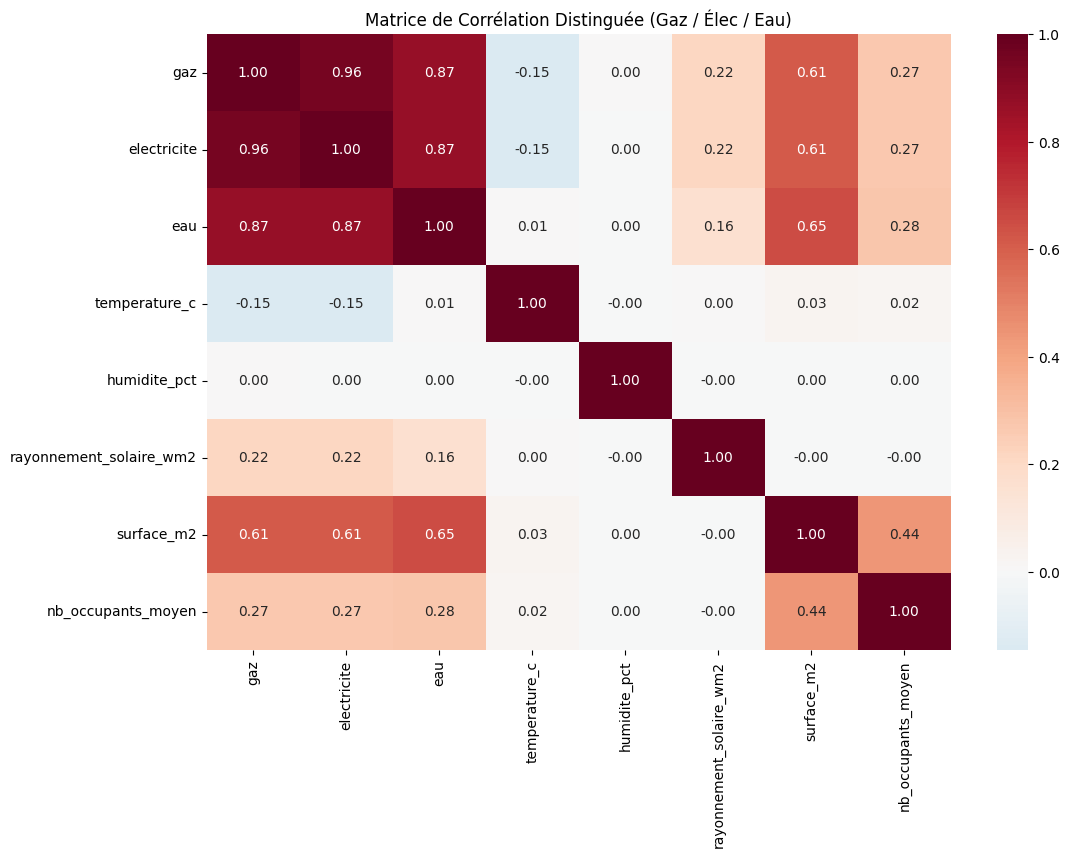

La matrice de corrélation a été exportée dans output/figures/matrice_correlation_energies.csv


In [14]:
df_pivot = df_conso_enrichies.pivot_table(
    index=['batiment_id', 'timestamp_hour', 'temperature_c', 'humidite_pct', 'rayonnement_solaire_wm2', 'vitesse_vent_kmh', 'surface_m2', 'nb_occupants_moyen', 'annee_construction'],
    columns='type_energie', 
    values='conso_mean'
).reset_index()


df_pivot.columns.name = None

cols_energies = [c for c in ['gaz', 'electricite', 'eau'] if c in df_pivot.columns]
cols_meteo_bat = ['temperature_c', 'humidite_pct', 'rayonnement_solaire_wm2', 'surface_m2', 'nb_occupants_moyen']

matrix_full = df_pivot[cols_energies + cols_meteo_bat].corr()


plt.figure(figsize=(12, 8))
sns.heatmap(matrix_full, annot=True, cmap='RdBu_r', center=0, fmt=".2f")
plt.title("Matrice de Corrélation Distinguée (Gaz / Élec / Eau)")
plt.show()


matrix_full.to_csv(f'../output/figures/matrice_correlation_energies.csv', sep=';', encoding='utf-8')

print(f"La matrice de corrélation a été exportée dans output/figures/matrice_correlation_energies.csv")

### Identifier les corrélations significatives

Avec les données actuelles, j'ai 3 véritables corrélations : 
- Consommation gaz avec surface en m2
- Consommation électricité avec surface en m2
- Consommation eau avec surface en m2

### Analyse de l'impact de la température sur la consommation de chauffage

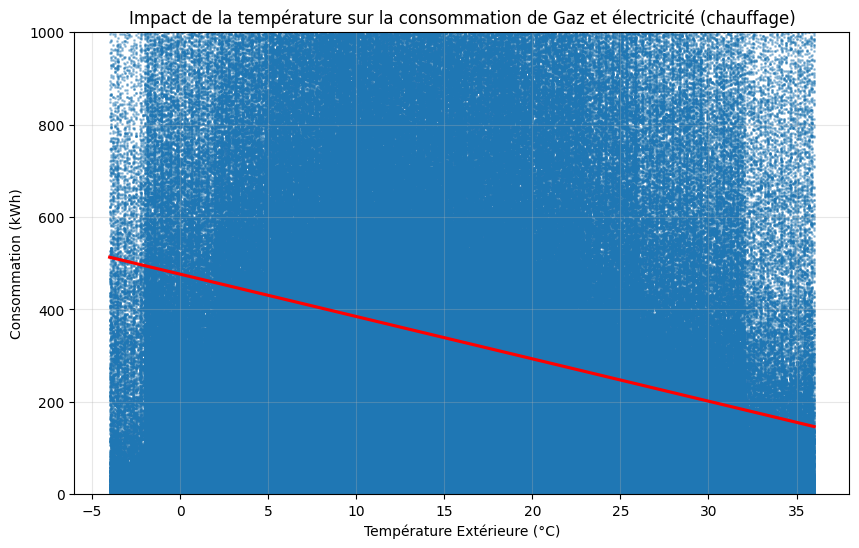

In [7]:
df_chauffage = df_conso_enrichies[df_conso_enrichies['type_energie'].isin(['gaz', 'electricite'])]

plt.figure(figsize=(10, 6))

sns.regplot(
    data=df_chauffage, 
    x='temperature_c', 
    y='conso_mean', 
    scatter_kws={'alpha':0.1, 's':1},
    line_kws={'color':'red'},
    ci=None
)

plt.title("Impact de la température sur la consommation de Gaz et électricité (chauffage)")
plt.xlabel("Température Extérieure (°C)")
plt.ylabel("Consommation (kWh)")
plt.ylim(0, 1000)
plt.grid(True, alpha=0.3)
plt.show()

### Effet du rayonnement solaire sur la consommation électrique

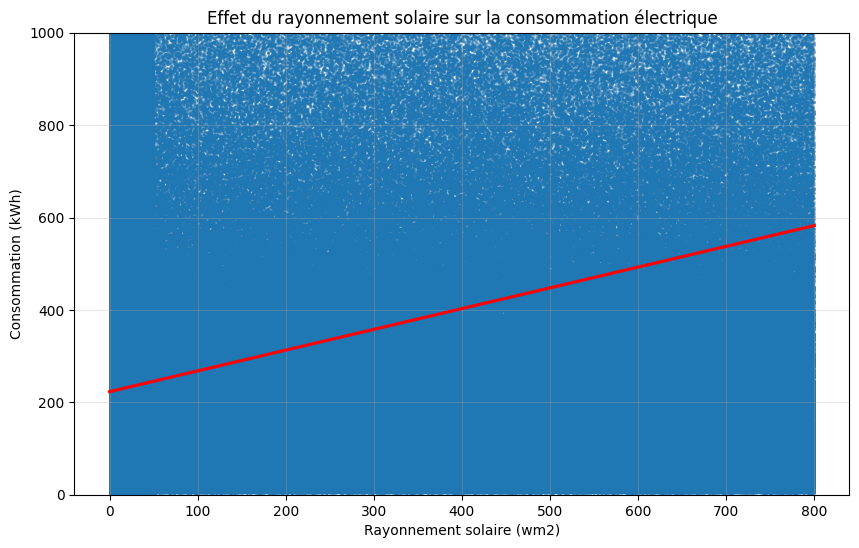

In [8]:
df_rayonnement_conso = df_conso_enrichies[df_conso_enrichies['type_energie'] == 'electrique']

plt.figure(figsize=(10, 6))

sns.regplot(
    data=df_chauffage, 
    x='rayonnement_solaire_wm2', 
    y='conso_mean', 
    scatter_kws={'alpha':0.1, 's':1},
    line_kws={'color':'red'},
    ci=None
)

plt.title("Effet du rayonnement solaire sur la consommation électrique")
plt.xlabel("Rayonnement solaire (wm2)")
plt.ylabel("Consommation (kWh)")
plt.ylim(0, 1000)
plt.grid(True, alpha=0.3)
plt.show()